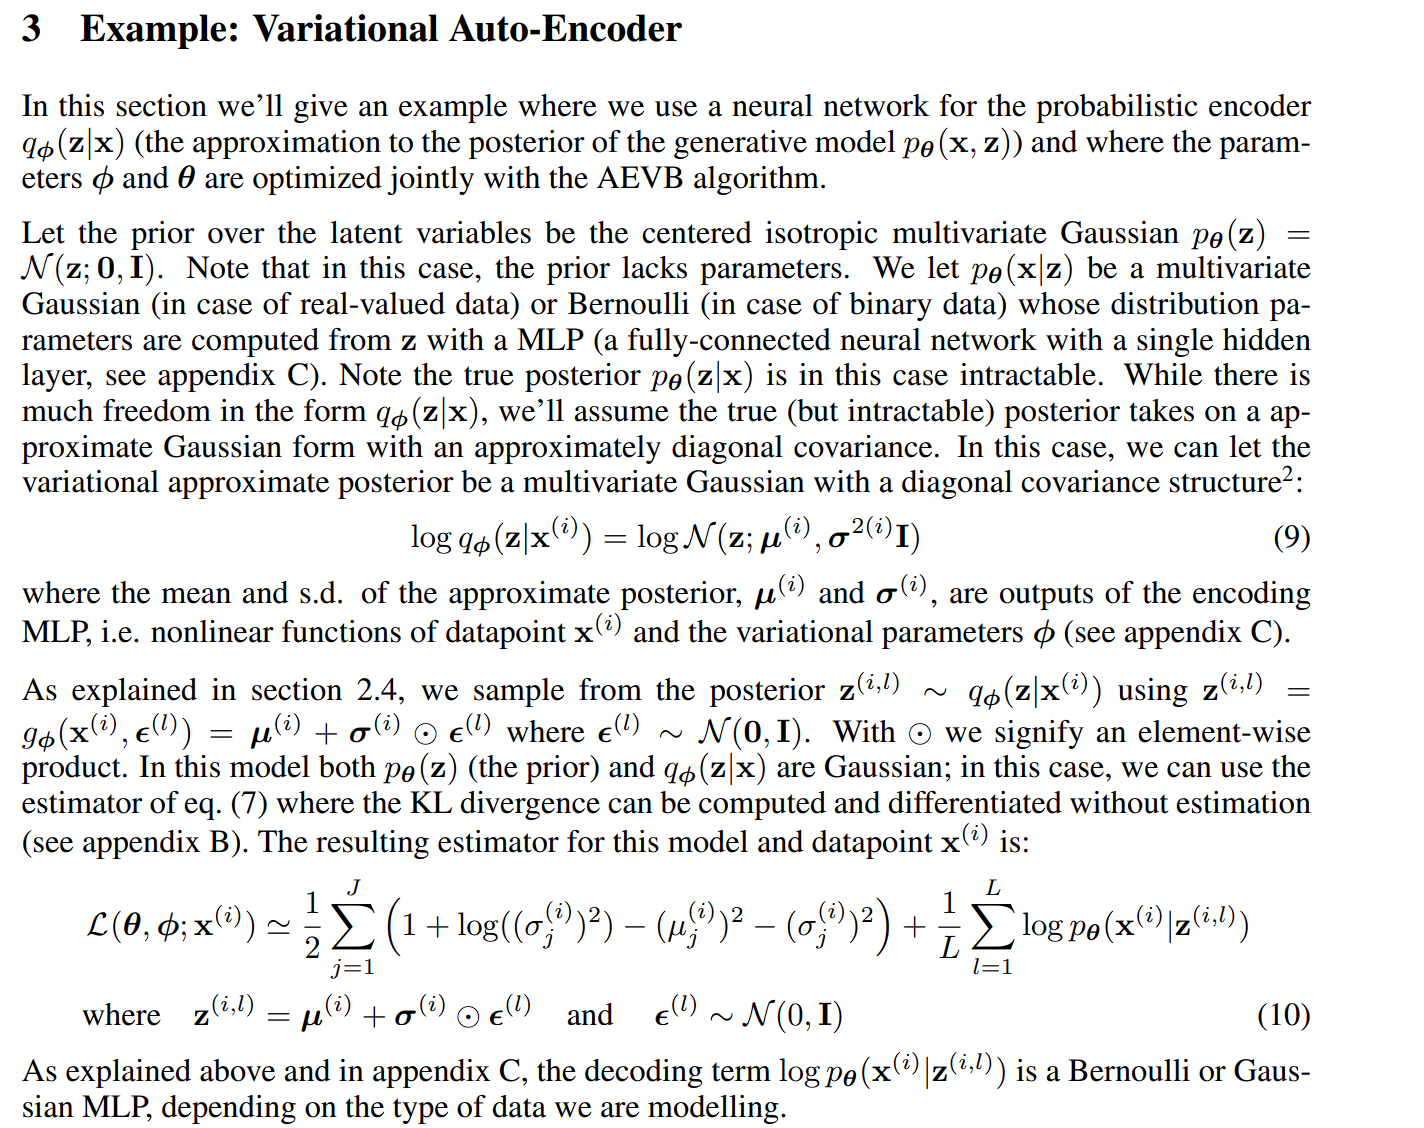

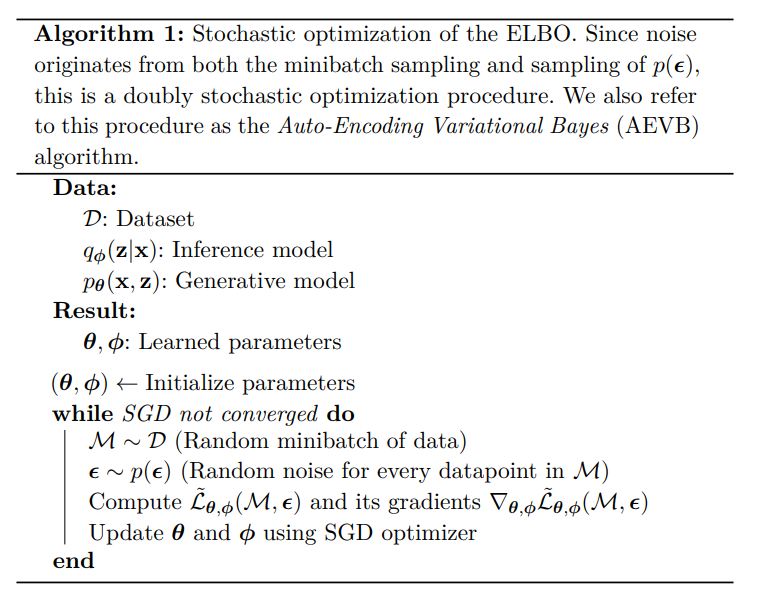

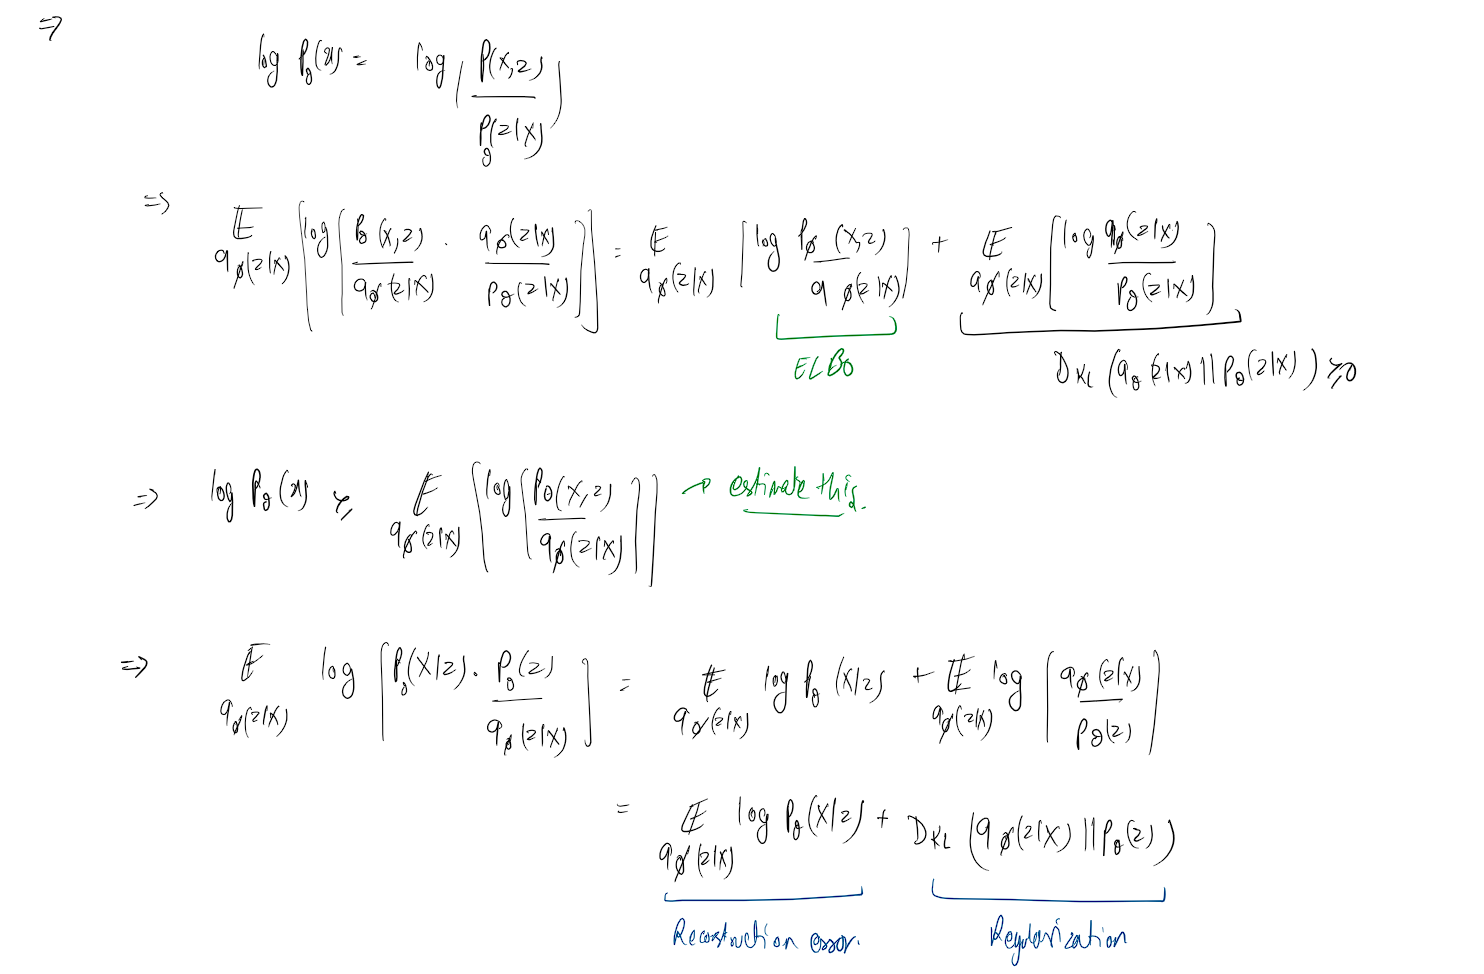

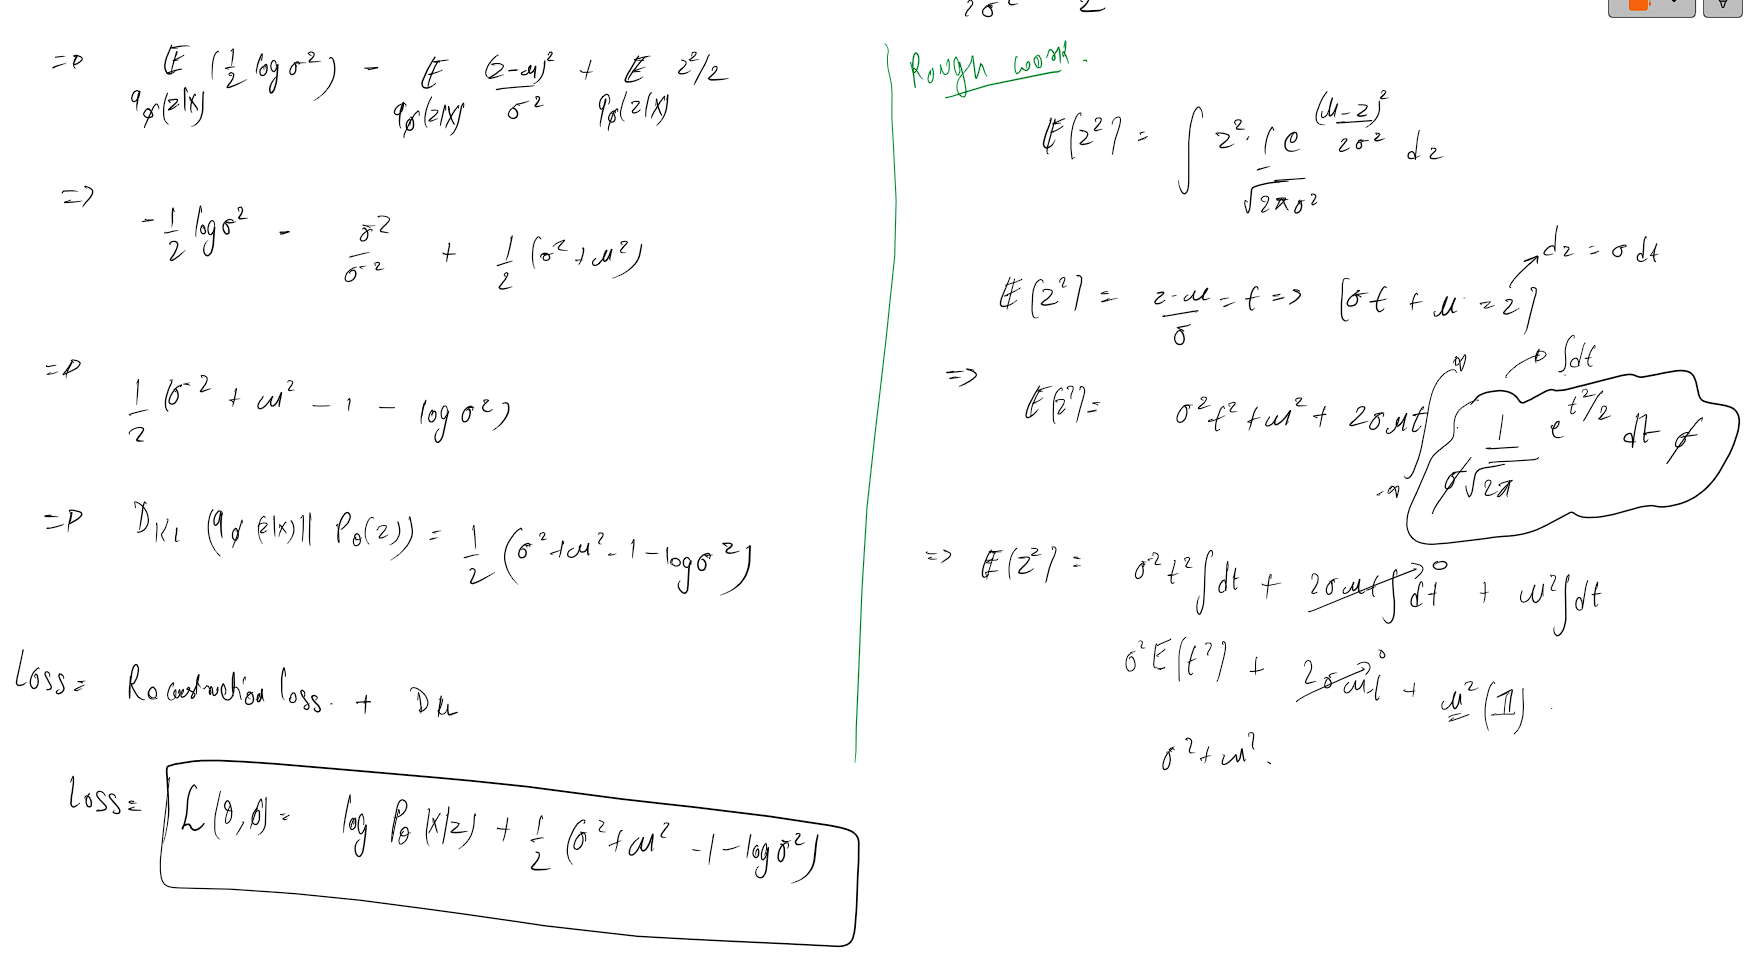

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class LinearLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()

        self.weight = nn.Parameter(torch.empty(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

        torch.nn.init.xavier_normal_(self.weight)

    def forward(self, x: torch.tensor):
        return x @ self.weight + self.bias


class Encoder(nn.Module):
    def __init__(self, x_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.linear_layer_1 = LinearLayer(x_dim, hidden_dim) # (N, H)
        self.linear_layer_2 = LinearLayer(hidden_dim, latent_dim) # (H, L)
        self.linear_layer_3 = LinearLayer(hidden_dim, latent_dim) # (H, L)

    def forward(self, x: torch.tensor):
        # x.shape  = (B, N)
        h = torch.sigmoid(self.linear_layer_1(x)) # (B, N) @ (N, H) --> (B, H)
        mu = self.linear_layer_2(h) # (B, H) @ (H, L) --> (B, L)
        log_var = self.linear_layer_3(h) # (B, H) @ (H, L) --> (B, L)

        return mu, log_var
    
    def reparameterization(self, mu: torch.tensor, log_var: torch.tensor):
        # sample eps from Gaussian Standard Normal Distribution
        eps = torch.randn_like(mu)
        std = torch.exp(0.5 * log_var)
        z = mu + std * eps
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, x_dim: int):
        super().__init__()

        self.linear_layer_1 = LinearLayer(latent_dim, hidden_dim)
        self.linear_layer_2 = LinearLayer(hidden_dim, hidden_dim)
        self.linear_layer_3 = LinearLayer(hidden_dim, x_dim)

    def forward(self, x):
        x = F.relu(self.linear_layer_1(x))
        x = F.relu(self.linear_layer_2(x))
        x = self.linear_layer_3(x)

        return torch.sigmoid(x)

class VariationalAutoEncoder(nn.Module):
    def __init__(self, x_dim: int, hidden_enc: int, hidden_dec: int, latent_dim: int):
        super().__init__()

        self.x_dim = x_dim
        self.hidden_enc = hidden_enc
        self.hidden_dec = hidden_dec
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(x_dim = x_dim, hidden_dim = hidden_enc, latent_dim = latent_dim)
        self.decoder = Decoder(latent_dim = latent_dim, hidden_dim = hidden_dec, x_dim = x_dim)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.encoder.reparameterization(mu, log_var)
        return self.decoder(z), mu, log_var

In [2]:
def kl_divergence(mu: torch.tensor, log_var: torch.tensor):
    return -0.5 * torch.sum(1 + log_var - torch.exp(log_var) - mu.pow(2), dim=-1)

## Training VAE on MNIST

In [3]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (torch.tensor(np.array(x_train)), torch.tensor(np.array(y_train))), (torch.tensor(np.array(x_test)), torch.tensor(np.array(y_test)))   

In [4]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts, rows=1, cols=2, save_path=None):
    plt.figure(figsize=(cols * 4, rows * 4))
    index = 1

    for img, title in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=12)
        plt.axis('off')
        index += 1

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)   # save high resolution

    plt.show()

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [5]:
x_train = x_train / 255.0
x_train = x_train.view(-1, 28 * 28)
mnsit_vae = VariationalAutoEncoder(
    x_dim=x_train.shape[-1],
    hidden_enc = 512,
    hidden_dec = 512,
    latent_dim = 8
)
optimizer = torch.optim.Adam(mnsit_vae.parameters(), lr = 0.001)

In [6]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F

def train_vae(model, x_train, optimizer, epochs=10, batch_size=128, device="cpu", anneal_epochs=20):
    model.train()
    model.to(device)

    dataset = TensorDataset(x_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        beta = min(1.0, epoch / anneal_epochs)
        
        loop = tqdm(dataloader, leave=True)
        for batch in loop:
            x = batch[0].to(device)

            x_tilde, mu, log_var = model(x)

            recon_loss = F.binary_cross_entropy(x_tilde, x, reduction="mean")
            
            kl_val = kl_divergence(mu, log_var)
            kl_loss = torch.mean(kl_val)

            loss = recon_loss + (beta * kl_loss * 0.01)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0:
                loop.set_description(f"Epoch {epoch}/{epochs} [beta={beta:.2f}]")
                loop.set_postfix(
                    loss=float(loss),
                    recon=float(recon_loss),
                    kl=float(kl_loss)
                )

    print("Training complete.")

In [7]:
train_vae(mnsit_vae, x_train, optimizer, epochs=300, batch_size=128)

Epoch 300/300 [beta=1.00]: 100%|██████████| 469/469 [00:07<00:00, 64.28it/s, kl=5.71, loss=0.211, recon=0.154]

Training complete.


In [8]:
x_test.shape

torch.Size([10000, 28, 28])

In [9]:
x_test = x_test / 255.0
x_test = x_test.view(10000, -1)
output, _, _ = mnsit_vae(x_test)
generated_images = output.view(output.shape[0], 28, 28)

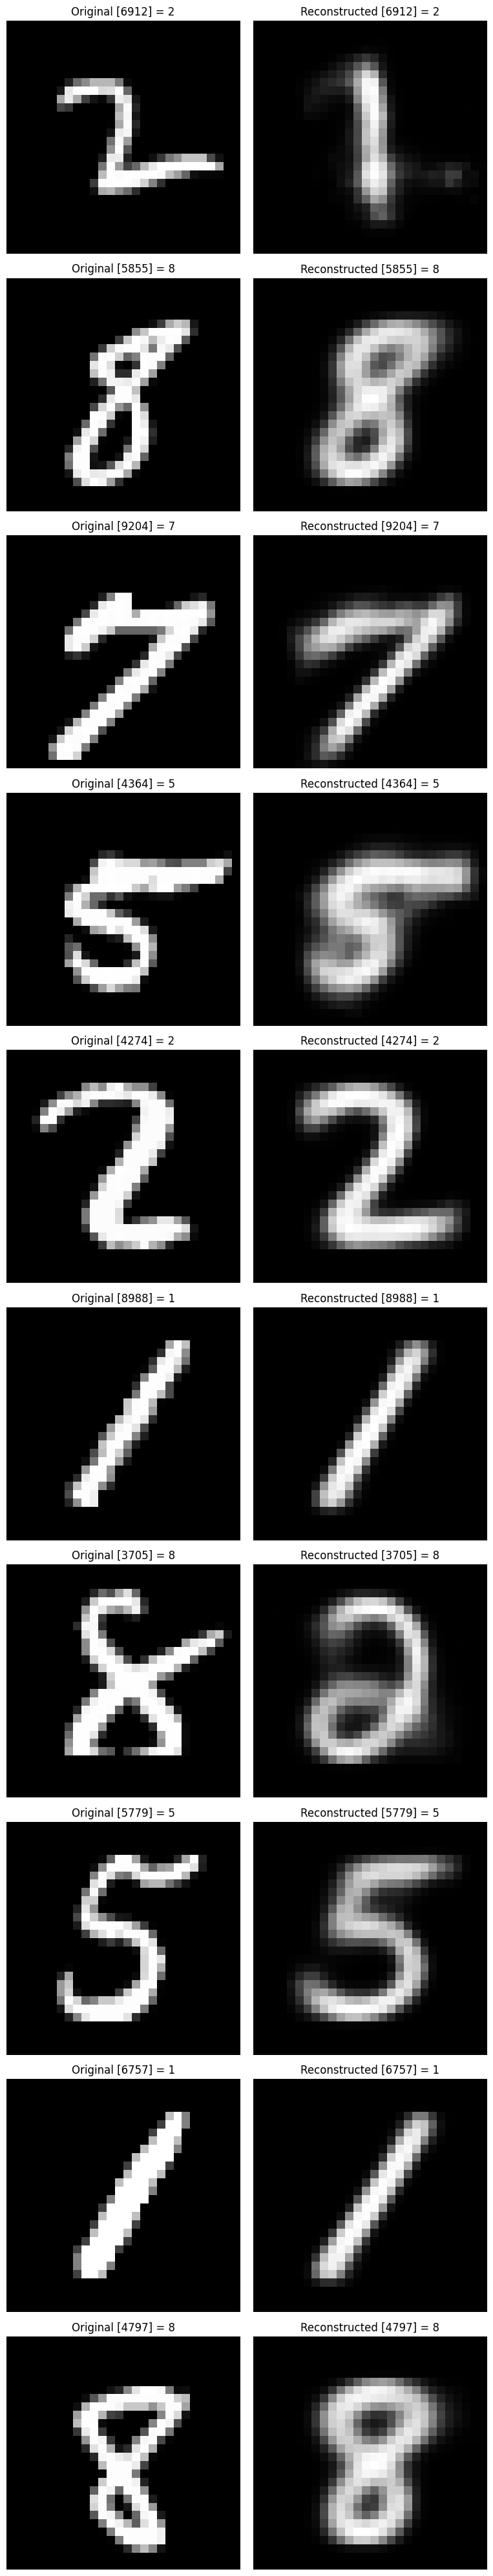

In [10]:
import random
images_2_show = []
titles_2_show = []

# reshape test images
x_test = x_test.view(-1, 28, 28)
generated_images = generated_images.view(-1, 28, 28).detach().numpy()   # ensure same shape

for i in range(10):  
    r = random.randint(0, len(x_test) - 1)

    # original
    images_2_show.append(x_test[r])
    titles_2_show.append(f"Original [{r}] = {y_test[r].item()}")

    # generated
    images_2_show.append(generated_images[r])
    titles_2_show.append(f"Reconstructed [{r}] = {y_test[r].item()}")
    
# show in rows of 2 (original + reconstructed)
show_images(images_2_show, titles_2_show, rows=10, cols=2, save_path = "mnist_reconstructions.png")

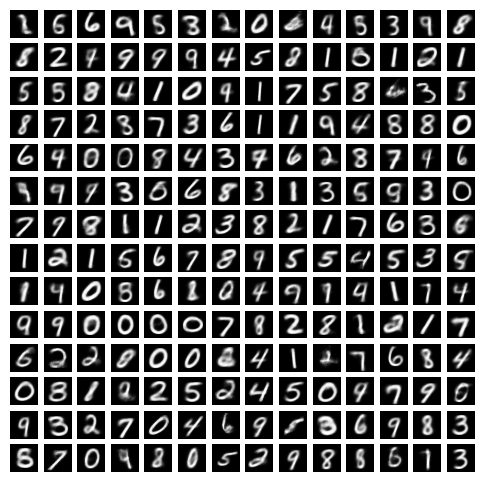

In [11]:
def generate_new_images(model: VariationalAutoEncoder, n_images: int = 16):
    latent_dim = model.encoder.linear_layer_2.weight.shape[1]  # gets latent dim safely

    # grid size
    rows = cols = int(n_images ** 0.5)

    fig, ax = plt.subplots(rows, cols, figsize=(6, 6))

    for r in range(rows):
        for c in range(cols):
            z = torch.randn(1, latent_dim)

            x_tilde = model.decoder(z)

            img = x_tilde.detach().cpu().view(28, 28)

            ax[r, c].imshow(img, cmap="gray")
            ax[r, c].axis("off")

    plt.show()

generate_new_images(mnsit_vae, 200)

## Save the Model

In [12]:
torch.save(mnsit_vae.state_dict(), "vae_weights_1.pth")
torch.save(mnsit_vae.state_dict(), "vae_weights_2.pth")

In [13]:
torch.save(mnsit_vae.state_dict(), "vae_weights_4.pth")
torch.save(mnsit_vae.state_dict(), "vae_weights_5.pth")

## Load the Model

In [14]:
mnsit_vae = VariationalAutoEncoder(
    x_dim = 28 * 28,
    hidden_enc = 512,
    hidden_dec = 512,
    latent_dim = 8
)

mnsit_vae.load_state_dict(torch.load("vae_weights_1.pth", weights_only=True))
mnsit_vae.eval()

VariationalAutoEncoder(
  (encoder): Encoder(
    (linear_layer_1): LinearLayer()
    (linear_layer_2): LinearLayer()
    (linear_layer_3): LinearLayer()
  )
  (decoder): Decoder(
    (linear_layer_1): LinearLayer()
    (linear_layer_2): LinearLayer()
    (linear_layer_3): LinearLayer()
  )
)

In [15]:
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
x_test = x_test / 255.0
x_test = x_test.view(x_test.shape[0], -1)
mnsit_vae(x_test)[0]

tensor([[5.5620e-13, 1.0585e-12, 9.5040e-13,  ..., 8.6795e-13, 7.7224e-13,
         9.3660e-13],
        [3.3802e-09, 3.4004e-09, 4.6241e-09,  ..., 3.0155e-09, 5.0358e-09,
         3.9072e-09],
        [2.1274e-11, 2.0542e-11, 1.9323e-11,  ..., 1.9039e-11, 1.5773e-11,
         1.4852e-11],
        ...,
        [5.2308e-08, 4.4407e-08, 4.5133e-08,  ..., 4.5527e-08, 4.2573e-08,
         5.6540e-08],
        [2.8811e-09, 2.8476e-09, 3.1224e-09,  ..., 3.1048e-09, 2.2898e-09,
         2.8959e-09],
        [1.4888e-08, 9.0029e-09, 1.3782e-08,  ..., 1.0472e-08, 1.3399e-08,
         1.2136e-08]], grad_fn=<SigmoidBackward0>)

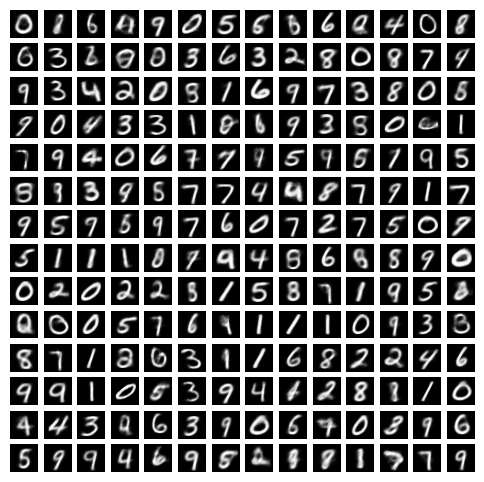

In [22]:
generate_new_images(mnsit_vae, 200)